# 2. Hough Transform

In [116]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import defaultdict

In [117]:
# Load image
image_runway = cv2.imread('runway.jpeg', cv2.IMREAD_GRAYSCALE)  # Make sure to use the correct path
image_SpaceXmap = cv2.imread('SpaceXmap.jpg')  # Make sure to use the correct path

### Canny Edge Detection

In [ ]:
def edge_detection(image, threshold1=50, threshold2=100):
    # Smooth the image using a Gaussian filter
    sigma = 1.4
    length = 5
    # Compute Gaussian filter
    k = length // 2  # Half size of the filter
    gaussian = np.zeros([length, length])  # Initialize a zero matrix for the Gaussian filter
    
    # Fill in the Gaussian filter with values based on the equation
    for i in range(length):
        for j in range(length):
            gaussian[i, j] = np.exp(-((i-k) ** 2 + (j-k) ** 2) / (2 * sigma ** 2))
    
    # Normalize the filter to ensure the sum of weights is 1
    gaussian /= 2 * np.pi * sigma ** 2
    gaussian = gaussian / np.sum(gaussian)  # Normalize by the sum of all values in the filter

    # Get image dimensions
    W, H = image.shape
    # Initialize a new image_SpaceXmap to store the smoothed result
    smoothed = np.zeros([W - k * 2, H - k * 2])

    # Apply the Gaussian filter using a sliding window approach
    for i in range(W - 2 * k):
        for j in range(H - 2 * k):
            smoothed[i, j] = np.sum(image[i:i+length, j:j+length] * gaussian)

    # Convert the result to an unsigned 8-bit integer type
    smoothed = np.uint8(smoothed)
    
    # Sobel filters for calculating gradients in x and y directions
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    W, H = smoothed.shape
    # Initialize matrices to store gradients and direction values
    gradients = np.zeros([W - 2, H - 2])
    direction = np.zeros([W - 2, H - 2])

    # Apply the Sobel operator to calculate the gradient magnitude and direction
    for i in range(W - 2):
        for j in range(H - 2):
            dx = np.sum(smoothed[i:i+3, j:j+3] * Gx)  # Calculate gradient in x-direction
            dy = np.sum(smoothed[i:i+3, j:j+3] * Gy)  # Calculate gradient in y-direction
            gradients[i, j] = np.sqrt(dx ** 2 + dy ** 2)  # Compute gradient magnitude
            # Compute gradient direction
            if dx == 0:
                direction[i, j] = np.pi / 2
            else:
                direction[i, j] = np.arctan(dy / dx)

    # Convert gradient magnitudes to uint8 type
    gradients = np.uint8(gradients)
    W, H = gradients.shape
    nms = np.copy(gradients[1:-1, 1:-1])  # Create a copy of the gradients for Non-Maximum Suppression

    # Perform NMS for each pixel in the image
    for i in range(1, W - 1):
        for j in range(1, H - 1):
            theta = direction[i, j]
            weight = np.tan(theta)  # Calculate weight based on the gradient direction
            if theta > np.pi / 4:
                d1 = [0, 1]
                d2 = [1, 1]
                weight = 1 / weight  # Adjust for different edge directions
            elif theta >= 0:
                d1 = [1, 0]
                d2 = [1, 1]
            elif theta >= - np.pi / 4:
                d1 = [1, 0]
                d2 = [1, -1]
                weight *= -1
            else:
                d1 = [0, -1]
                d2 = [1, -1]
                weight = -1 / weight

            # Calculate the gradient values at the neighboring positions
            g1 = gradients[i + d1[0], j + d1[1]]
            g2 = gradients[i + d2[0], j + d2[1]]
            g3 = gradients[i - d1[0], j - d1[1]]
            g4 = gradients[i - d2[0], j - d2[1]]

            # Combine gradients based on direction and weights
            grade_count1 = g1 * weight + g2 * (1 - weight)
            grade_count2 = g3 * weight + g4 * (1 - weight)

            # Suppress non-maximal values
            if grade_count1 > gradients[i, j] or grade_count2 > gradients[i, j]:
                nms[i - 1, j - 1] = 0
    # Perform double thresholding
        # Initialize variables for visited pixels and output image
    visited = np.zeros_like(nms)
    output_image = nms.copy()
    W, H = output_image.shape

    def dfs(i, j):
        # Depth-first search to connect pixels above threshold2
        if i >= W or i < 0 or j >= H or j < 0 or visited[i, j] == 1:
            return
        visited[i, j] = 1
        if output_image[i, j] > threshold1:
            output_image[i, j] = 255  # Mark as strong edge
            # Recursively visit neighboring pixels
            dfs(i-1, j-1)
            dfs(i-1, j)
            dfs(i-1, j+1)
            dfs(i, j-1)
            dfs(i, j+1)
            dfs(i+1, j-1)
            dfs(i+1, j)
            dfs(i+1, j+1)
        else:
            output_image[i, j] = 0  # Mark as weak edge

    # Perform double thresholding to classify edges
    for w in range(W):
        for h in range(H):
            if visited[w, h] == 1:
                continue
            if output_image[w, h] >= threshold2:
                dfs(w, h)  # Strong edge found, trace it
            elif output_image[w, h] <= threshold1:
                output_image[w, h] = 0  # Weak or no edge
                visited[w, h] = 1

    # Remove all unvisited weak edges
    for w in range(W):
        for h in range(H):
            if visited[w, h] == 0:
                output_image[w, h] = 0

    return output_image

### Edge Detection in Runway Image 

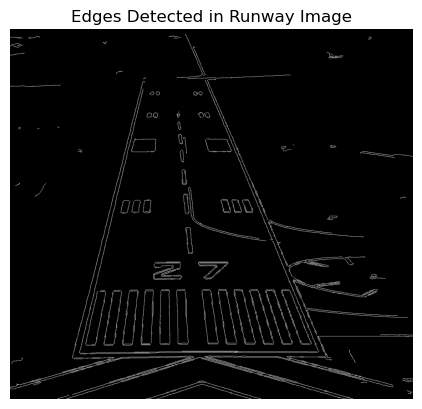

In [119]:
edges_runway = edge_detection(image_runway, 50, 180)
plt.imshow(edges_runway, cmap='gray')
plt.title("Edges Detected in Runway Image")
plt.axis('off')
plt.show()

### Hough transform for line detection (runway)

In [120]:
def custom_hough_lines(edges, rho_res=1, theta_res=np.pi / 180, threshold=150):
    # Get the shape of the edge image
    height, width = edges.shape
    
    # Define the range of rho and theta in polar coordinates
    max_rho = int(np.sqrt(height ** 2 + width ** 2))
    rhos = np.arange(-max_rho, max_rho + 1, rho_res)
    thetas = np.arange(0, np.pi, theta_res)
    
    # Initialize the accumulator array
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=int)
    
    # Find the coordinates of non-zero pixels in the edge image (edge points)
    edge_points = np.argwhere(edges)
    
    # Accumulation process: voting for each edge point
    for y, x in edge_points:
        for theta_idx, theta in enumerate(thetas):
            # Calculate the value of rho
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_idx = np.where(rhos == rho)[0][0]  # Find the index corresponding to rho
            accumulator[rho_idx, theta_idx] += 1   # Cast a vote
            
    # Find (rho, theta) pairs that meet the threshold
    lines = []
    for rho_idx, theta_idx in np.argwhere(accumulator >= threshold):
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        lines.append((rho, theta))
    
    return lines

### overlap in the image

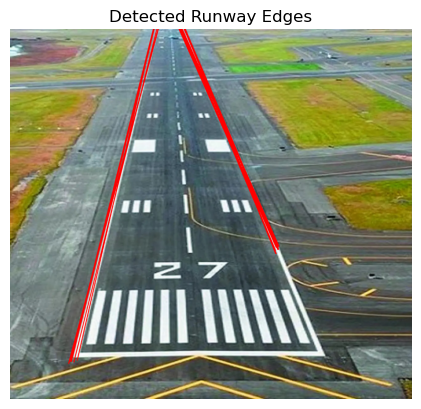

In [121]:
# Using Hough Transform from OpenCV
lines = custom_hough_lines(edges_runway, threshold=180)

# Draw the detected lines
output_image = cv2.imread('runway.jpeg')
for rho, theta in lines:
    # filter the lines based on the angle
    if theta < np.pi / 6  or theta > np.pi * 5 / 6:
        x1 = int(rho * np.cos(theta) - 1000 * np.sin(theta))
        y1 = int(rho * np.sin(theta) + 1000 * np.cos(theta))
        x2 = int(rho * np.cos(theta) + 1000 * np.sin(theta))
        y2 = int(rho * np.sin(theta) - 1000 * np.cos(theta))
    # draw the lines on the image
    cv2.line(output_image, (x1, y1), (x2, y2), (0, 0, 255), 2)
output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
plt.imshow(output_image)
plt.title("Detected Runway Edges")
plt.axis('off')
plt.show()

### Edge Detection in Space X Image
- first we can remove some noisy, and save the gray part
- then we could use canny detection

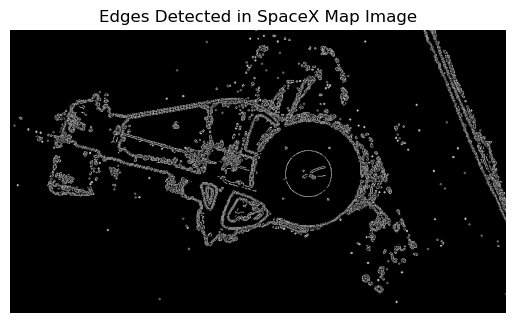

In [135]:
image_rgb = cv2.cvtColor(image_SpaceXmap, cv2.COLOR_BGR2RGB)
# transform the image to HSV color space
image_hsv = cv2.cvtColor(image_SpaceXmap, cv2.COLOR_BGR2HSV)
# define range of white color in HSV
lower_white = np.array([0, 0, 200])   # min value: low saturation, low brightness
upper_white = np.array([180, 60, 255])  # max value: high saturation, high brightness
# use mask to filter out the white pixels
mask = cv2.inRange(image_hsv, lower_white, upper_white)
filtered_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
filtered_image = cv2.cvtColor(filtered_image, cv2.COLOR_RGB2GRAY)
edges_spaceXmap = edge_detection(filtered_image, 20, 30)
plt.imshow(edges_spaceXmap, cmap='gray')
plt.title("Edges Detected in SpaceX Map Image")
plt.axis('off')
plt.show()

### Hough transform for circle detection (Space X)
- You need around 2mins to run the code 

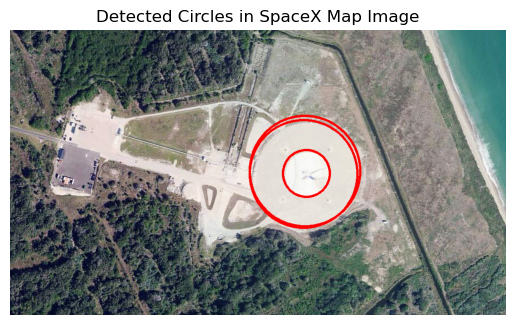

In [139]:
def hough_circles(edges, min_radius, max_radius, radius_step, theta_bins, vote_threshold):
    # Image dimensions
    height, width = edges.shape[:2]
    
    # Calculate theta increment
    theta_step = int(360 / theta_bins)
    thetas = np.arange(0, 360, step=theta_step)
    radii = np.arange(min_radius, max_radius, step=radius_step)
    
    # Precompute cosine and sine values
    cos_values = np.cos(np.deg2rad(thetas))
    sin_values = np.sin(np.deg2rad(thetas))
    
    # Generate circle parameter candidates
    candidate_circles = [
        (radius, int(radius * cos_values[t]), int(radius * sin_values[t]))
        for radius in radii
        for t in range(theta_bins)
    ]
    
    # Initialize accumulator for voting
    vote_accumulator = defaultdict(int)
    
    # Perform voting for each edge pixel
    for y in range(height):
        for x in range(width):
            if edges[y, x] != 0:  # Edge pixel detected
                for radius, dx, dy in candidate_circles:
                    xc = x - dx
                    yc = y - dy
                    vote_accumulator[(xc, yc, radius)] += 1
    
    # Sort circles by votes
    detected_circles = [
        (xc, yc, radius, votes / theta_bins)
        for (xc, yc, radius), votes in sorted(vote_accumulator.items(), key=lambda item: -item[1])
        if votes / theta_bins >= vote_threshold
    ]
    
    # Refine detected circles to remove duplicates
    proximity_threshold = 5
    filtered_circles = []
    for xc, yc, radius, confidence in detected_circles:
        if all(
            abs(xc - xc_ref) > proximity_threshold or 
            abs(yc - yc_ref) > proximity_threshold or 
            abs(radius - r_ref) > proximity_threshold
            for xc_ref, yc_ref, r_ref, _ in filtered_circles
        ):
            filtered_circles.append((xc, yc, radius, confidence))
    detected_circles = filtered_circles
    
    # Draw detected circles on the output image
    visualization_image = cv2.imread('SpaceXmap.jpg').copy()
    for xc, yc, radius, _ in detected_circles:
        cv2.circle(visualization_image, (xc, yc), radius, (0, 0, 255), thickness=3)
    
    visualization_image = cv2.cvtColor(visualization_image, cv2.COLOR_BGR2RGB)
    return visualization_image, detected_circles

result, circles = hough_circles(edges_spaceXmap, 50, 120, 1, 100, 0.41)
plt.imshow(result)
plt.title("Detected Circles in SpaceX Map Image")
plt.axis('off')
plt.show()
